<div align="center">

# Email Routing with Large Language Models

### Automating Customer Support Ticket Classification with GPT-2 and DistilBERT

**Natural Language Processing 2025-26** | University of Verona

</div>

---

### Project Overview

Customer support teams handle thousands of emails daily. Routing each email to the right department is a repetitive yet critical task — misrouted tickets cause delays and frustration. In this project, we explore whether Large Language Models can learn to **automatically classify customer support emails** into one of five departments:

> *Technical Support* · *Customer Service* · *Billing and Payments* · *Sales and Pre-Sales* · *General Inquiry*

We design and compare **three progressively stronger agents**, moving from a frozen language model to a fully fine-tuned discriminative classifier:

| | Agent | Approach | Model |
|---|-------|----------|-------|
| 1 | Frozen prompting | Zero-shot log-likelihood scoring | GPT-2, DistilGPT-2 |
| 2 | LoRA fine-tuning | Parameter-efficient adaptation | GPT-2, DistilGPT-2 |
| 3 | Discriminative classifier | Supervised sequence classification | DistilBERT |

**Dataset:** [customer-support-tickets](https://huggingface.co/datasets/Tobi-Bueck/customer-support-tickets) (Tobi-Bueck, HuggingFace) — filtered to English emails across the 5 target departments.

---

## 0. Setup and Imports

Import all required libraries, suppress noisy library warnings, and detect the best available compute device (CUDA for NVIDIA GPUs, MPS for Apple Silicon, or CPU as fallback).

In [1]:
import os
import gc
import time
import tracemalloc
import warnings
import logging
from collections import Counter

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

import transformers
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,
    DistilBertTokenizer, DistilBertForSequenceClassification,
)

from datapreparation import load_and_prepare_data

# Suppress noisy library logs and warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
transformers.logging.set_verbosity_error()
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

# Device detection
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Data Loading and Exploration

Load the customer support ticket dataset using `load_and_prepare_data()` from `datapreparation.py`. This filters for English emails, keeps only the 5 target departments, shuffles, and splits into train (80%), validation (10%), and test (10%) sets.

In [2]:
train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"Labels: {label_list}")

Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})
Train size: 13249
Validation size: 1656
Test size: 1657
Labels: ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Sales and Pre-Sales', 'Technical Support']


The dataset contains 13,249 training, 1,656 validation, and 1,657 test samples. The class distribution is heavily imbalanced: Technical Support dominates (~49%), while General Inquiry is the smallest class (~2.5%).

Visualize the label distribution across train, validation, and test splits to check for class imbalance.

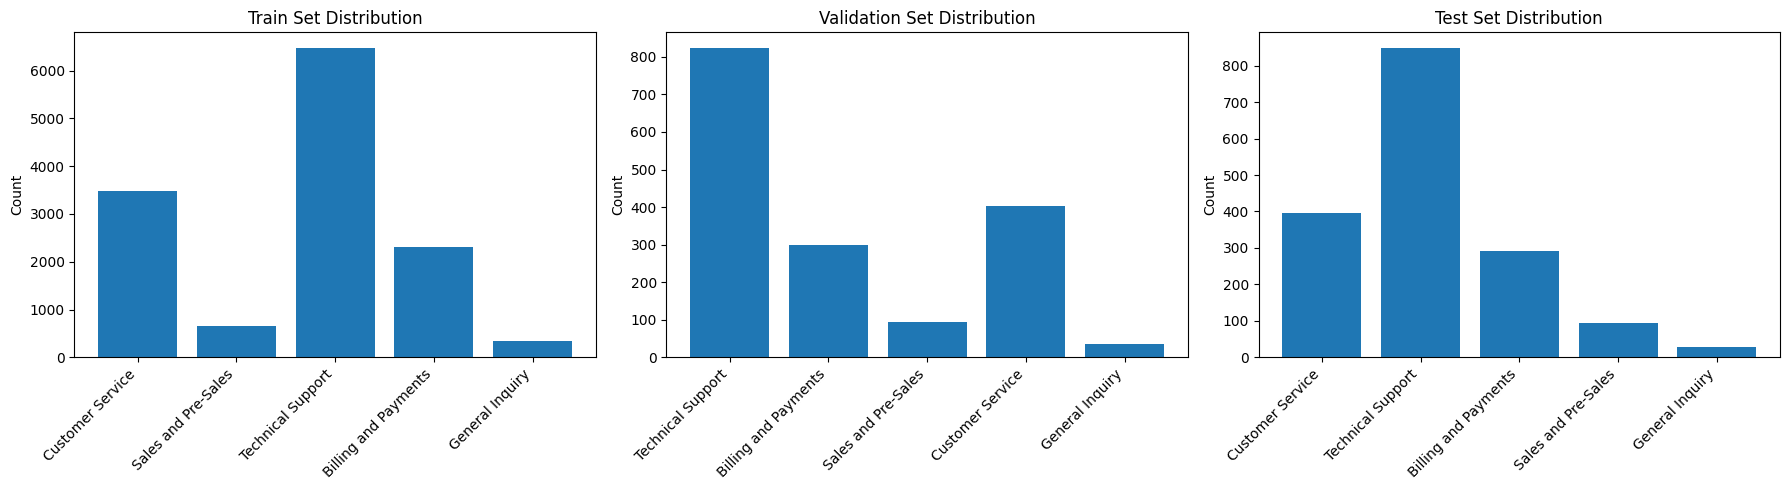

In [3]:
# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, split) in zip(axes, [("Train", train_ds), ("Validation", val_ds), ("Test", test_ds)]):
    counts = Counter(split["queue"])
    ax.bar(range(len(counts)), counts.values())
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.keys(), rotation=45, ha="right")
    ax.set_title(f"{name} Set Distribution")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

The bar charts confirm the class imbalance is consistent across all three splits. Technical Support has roughly 6x more samples than Sales and Pre-Sales, and 19x more than General Inquiry. This imbalance will affect model performance, especially for minority classes.

Print a few sample emails to understand the structure of the data (subject, body, and assigned department).

In [4]:
# Inspect a few examples
for i in range(3):
    print(f"--- Example {i+1} ---")
    print(f"Subject: {train_ds[i]['subject']}")
    print(f"Body: {train_ds[i]['body'][:200]}...")
    print(f"Department: {train_ds[i]['queue']}")
    print()

--- Example 1 ---
Subject: Guidance on Investment Data Analytics
Body: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions....
Department: Customer Service

--- Example 2 ---
Subject: None
Body: Dear customer support, the data analytics tool is failing to process investment data efficiently. The problem might be due to software compatibility issues. After updating the associated software devi...
Department: Sales and Pre-Sales

--- Example 3 ---
Subject: Concern Regarding CRM System Malfunction
Body: Dear Support Team, our marketing agency is facing issues with the Salesforce CRM system, which is disrupting our client data management process. It seems that recent software updates or integration er...
Department: Customer Service



Each email has a subject (which can be `None`), a body with the full message text, and a queue (department label). The emails vary in length and formality, and some subjects are missing — the model needs to handle both fields.

---
## 2. Agent 1: Routing with Prompting (Frozen GPT-2)

This agent uses a pretrained GPT-2 model **without any training or weight updates** (frozen). Classification is done via **log-likelihood scoring**: for each email, we build an instruction-style prompt and compute the probability of each department name as a completion. The department with the highest normalized log-probability is selected as the prediction.

Define the helper functions for Agent 1:
- `build_prompt`: constructs an instruction-style prompt from the email subject and body.
- `score_labels_gpt2`: scores each department label by computing its log-likelihood as a completion of the prompt. Uses KV-cache to avoid redundant computation — the prompt is forwarded once and cached, then only the label tokens are forwarded for each candidate.
- `evaluate_gpt2_prompting`: runs the scoring over an entire dataset split, tracking time and memory.

In [5]:
def build_prompt(subject, body, max_body_chars=500):
    """Build an instruction-style prompt for email routing."""
    body_truncated = body[:max_body_chars].strip()
    prompt = (
        "Classify the following customer support email into exactly one department.\n"
        "Departments: Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry\n\n"
        f"Subject: {subject}\n"
        f"Body: {body_truncated}\n\n"
        "Department:"
    )
    return prompt


def score_labels_gpt2(model, tokenizer, prompt, label_list, device):
    """Score each label using KV-cache: forward the prompt once, then score each label's tokens."""
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        prompt_out = model(prompt_ids, use_cache=True)
        past_kv = prompt_out.past_key_values
        last_logit = prompt_out.logits[:, -1, :]
        log_probs = torch.nn.functional.log_softmax(last_logit, dim=-1)

        scores = {}
        for label in label_list:
            label_ids = tokenizer.encode(" " + label, add_special_tokens=False)
            total_log_prob = log_probs[0, label_ids[0]].item()

            cached = past_kv
            for i in range(1, len(label_ids)):
                prev_token = torch.tensor([[label_ids[i - 1]]], device=device)
                out = model(prev_token, past_key_values=cached, use_cache=True)
                cached = out.past_key_values
                lp = torch.nn.functional.log_softmax(out.logits[:, -1, :], dim=-1)
                total_log_prob += lp[0, label_ids[i]].item()

            scores[label] = total_log_prob / len(label_ids)

    return max(scores, key=scores.get)


def evaluate_gpt2_prompting(model, tokenizer, dataset, label_list, device, desc="Evaluating"):
    """Run prompting-based evaluation on a dataset split. Returns predictions, true labels, elapsed time, peak CPU memory."""
    model.eval()
    predictions = []
    true_labels = []

    tracemalloc.start()
    start_time = time.time()

    for example in tqdm(dataset, desc=desc):
        prompt = build_prompt(example["subject"], example["body"])
        pred = score_labels_gpt2(model, tokenizer, prompt, label_list, device)
        predictions.append(pred)
        true_labels.append(example["queue"])

    elapsed = time.time() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return predictions, true_labels, elapsed, peak_memory

### 2.1 GPT-2 Prompting

Load the pretrained GPT-2 model (124M parameters, frozen) and run a sanity check on a single test example before evaluating on the full test set.

In [6]:
# Load GPT-2 (frozen)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

# Quick sanity check on one example
sample_prompt = build_prompt(test_ds[0]["subject"], test_ds[0]["body"])
sample_pred = score_labels_gpt2(gpt2_model, gpt2_tokenizer, sample_prompt, label_list, device)
print(f"Sample prediction: {sample_pred}")
print(f"True label: {test_ds[0]['queue']}")

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

Sample prediction: Customer Service
True label: Customer Service


Evaluate the frozen GPT-2 model on the full test set. Print accuracy, per-class precision/recall, inference time, and peak memory usage.

In [7]:
# Evaluate GPT-2 on the full test set
gpt2_preds, gpt2_true, gpt2_time, gpt2_mem = evaluate_gpt2_prompting(
    gpt2_model, gpt2_tokenizer, test_ds, label_list, device, desc="GPT-2 Prompting"
)

gpt2_acc = accuracy_score(gpt2_true, gpt2_preds)
print(f"\nGPT-2 Prompting Accuracy: {gpt2_acc:.4f}")
print(f"Time: {gpt2_time:.1f}s | Peak CPU Memory: {gpt2_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(gpt2_true, gpt2_preds, target_names=label_list, zero_division=0))

GPT-2 Prompting: 100%|██████████| 1657/1657 [04:52<00:00,  5.67it/s]


GPT-2 Prompting Accuracy: 0.2269
Time: 292.4s | Peak CPU Memory: 0.7 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.29      0.27      0.28       291
    Customer Service       0.20      0.21      0.20       395
     General Inquiry       0.00      0.00      0.00        29
 Sales and Pre-Sales       0.06      0.45      0.11        93
   Technical Support       0.59      0.20      0.30       849

            accuracy                           0.23      1657
           macro avg       0.23      0.23      0.18      1657
        weighted avg       0.40      0.23      0.26      1657



**GPT-2 Prompting Results:** 22.7% accuracy — barely above random chance (20% for 5 classes). The model heavily over-predicts "Sales and Pre-Sales" (45% recall but only 6% precision) while completely missing "General Inquiry" (0% recall). This is expected: GPT-2 is a base language model trained for next-token prediction on internet text, not for following instructions. It picks labels based on token probability rather than email content understanding.

### 2.2 DistilGPT-2 Prompting

Load the pretrained DistilGPT-2 model (80M parameters, frozen). Same approach as GPT-2 above, but with a smaller distilled model. Free the GPT-2 model from memory first, then evaluate on the full test set.

In [8]:
# Load DistilGPT-2 (frozen)
distilgpt2_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
distilgpt2_model = GPT2LMHeadModel.from_pretrained("distilgpt2").to(device)
distilgpt2_model.eval()

# Free GPT-2 memory if it exists
if 'gpt2_model' in dir():
    del gpt2_model
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Evaluate DistilGPT-2 on the full test set
distilgpt2_preds, distilgpt2_true, distilgpt2_time, distilgpt2_mem = evaluate_gpt2_prompting(
    distilgpt2_model, distilgpt2_tokenizer, test_ds, label_list, device, desc="DistilGPT-2 Prompting"
)

distilgpt2_acc = accuracy_score(distilgpt2_true, distilgpt2_preds)
print(f"\nDistilGPT-2 Prompting Accuracy: {distilgpt2_acc:.4f}")
print(f"Time: {distilgpt2_time:.1f}s | Peak CPU Memory: {distilgpt2_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(distilgpt2_true, distilgpt2_preds, target_names=label_list, zero_division=0))

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

DistilGPT-2 Prompting: 100%|██████████| 1657/1657 [03:02<00:00,  9.07it/s]


DistilGPT-2 Prompting Accuracy: 0.2842
Time: 182.7s | Peak CPU Memory: 0.7 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.33      0.01      0.02       291
    Customer Service       0.22      0.55      0.31       395
     General Inquiry       0.00      0.00      0.00        29
 Sales and Pre-Sales       0.09      0.26      0.14        93
   Technical Support       0.60      0.27      0.37       849

            accuracy                           0.28      1657
           macro avg       0.25      0.22      0.17      1657
        weighted avg       0.42      0.28      0.27      1657



**DistilGPT-2 Prompting Results:** 28.4% accuracy — slightly better than GPT-2 but still near random. DistilGPT-2 is ~1.6x faster (183s vs 292s) due to having 6 layers instead of 12, but shows the same fundamental limitation: it over-predicts "Customer Service" (55% recall, 22% precision) and completely ignores "General Inquiry". Both frozen models confirm that base GPT-2 models cannot perform zero-shot classification reliably — fine-tuning is needed.

### 2.3 Prompt Sensitivity Analysis

The performance of a frozen language model depends heavily on how the prompt is structured. Since GPT-2 was not trained to follow instructions, different framings can bias it toward different token completions. We test four prompt variants to quantify this effect:

| Variant | Strategy | Description |
|---------|----------|-------------|
| **A** | Instruction + department list | Lists all 5 departments explicitly in the prompt *(baseline from sections 2.1–2.2)* |
| **B** | Minimal | No instructions, no department list — just the email text followed by `"Department:"` |
| **C** | Few-shot (5 examples) | One short labeled example per department before the test email, leveraging in-context learning |
| **D** | Role-based | Frames the model as "an email routing system" with explicit department list |

All variants end with `"Department:"` so the log-likelihood label scoring mechanism is identical — only the preceding context differs. This isolates the effect of prompt framing on classification accuracy.

In [ ]:
def build_prompt_B(subject, body, max_body_chars=500):
    """Variant B: Minimal — just the email content followed by 'Department:', no instructions or department list."""
    body_truncated = body[:max_body_chars].strip()
    return (
        f"Subject: {subject}\n"
        f"Body: {body_truncated}\n\n"
        "Department:"
    )


def build_prompt_C(subject, body, max_body_chars=300):
    """Variant C: Few-shot — one short example per department for in-context learning.
    Uses max_body_chars=300 to leave room for the 5 examples within GPT-2's 1024-token context."""
    body_truncated = body[:max_body_chars].strip()
    return (
        "Classify each customer email into the correct department.\n\n"
        "Email: My software keeps crashing after the latest update.\n"
        "Department: Technical Support\n\n"
        "Email: I need help updating my account details.\n"
        "Department: Customer Service\n\n"
        "Email: I was double-charged on my last invoice.\n"
        "Department: Billing and Payments\n\n"
        "Email: Can I get a demo of your enterprise plan?\n"
        "Department: Sales and Pre-Sales\n\n"
        "Email: Where are your offices located?\n"
        "Department: General Inquiry\n\n"
        f"Email: {subject} {body_truncated}\n"
        "Department:"
    )


def build_prompt_D(subject, body, max_body_chars=500):
    """Variant D: Role-based — frames the model as an email routing system with explicit departments."""
    body_truncated = body[:max_body_chars].strip()
    return (
        "You are an email routing system for a company with these departments: "
        "Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry.\n"
        "Read the following email and classify it into one department.\n\n"
        f"Subject: {subject}\n"
        f"Body: {body_truncated}\n\n"
        "Department:"
    )


def evaluate_prompt_variant(model, tokenizer, dataset, label_list, device, prompt_fn, desc="Evaluating"):
    """Evaluate a prompt variant on the full dataset. Returns accuracy only (reuses score_labels_gpt2 from cell 14)."""
    model.eval()
    preds, truths = [], []
    for example in tqdm(dataset, desc=desc):
        prompt = prompt_fn(example["subject"], example["body"])
        pred = score_labels_gpt2(model, tokenizer, prompt, label_list, device)
        preds.append(pred)
        truths.append(example["queue"])
    return accuracy_score(truths, preds)

In [ ]:
import pandas as pd

# Reuse Variant A results from sections 2.1–2.2 (no redundant re-evaluation)
gpt2_variant_accs = {"A: Instruction + list": gpt2_acc}
distilgpt2_variant_accs = {"A: Instruction + list": distilgpt2_acc}

new_variants = {
    "B: Minimal": build_prompt_B,
    "C: Few-shot": build_prompt_C,
    "D: Role-based": build_prompt_D,
}

# --- DistilGPT-2 (already in memory from section 2.2) ---
print("=== DistilGPT-2 Prompt Variants ===")
for name, fn in new_variants.items():
    acc = evaluate_prompt_variant(
        distilgpt2_model, distilgpt2_tokenizer, test_ds, label_list, device, fn,
        desc=f"DistilGPT-2 [{name}]"
    )
    distilgpt2_variant_accs[name] = acc
    print(f"  {name}: {acc:.1%}\n")

# --- GPT-2 (reload for prompt analysis) ---
print("=== GPT-2 Prompt Variants ===")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

for name, fn in new_variants.items():
    acc = evaluate_prompt_variant(
        gpt2_model, gpt2_tokenizer, test_ds, label_list, device, fn,
        desc=f"GPT-2 [{name}]"
    )
    gpt2_variant_accs[name] = acc
    print(f"  {name}: {acc:.1%}\n")

# Free the reloaded GPT-2 model
del gpt2_model
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# --- Results Table ---
variant_labels = ["A: Instruction + list", "B: Minimal", "C: Few-shot", "D: Role-based"]
gpt2_accs_list = [gpt2_variant_accs[v] for v in variant_labels]
dgpt2_accs_list = [distilgpt2_variant_accs[v] for v in variant_labels]

prompt_df = pd.DataFrame({
    "Prompt Variant": variant_labels,
    "GPT-2 Accuracy": [f"{x:.1%}" for x in gpt2_accs_list],
    "DistilGPT-2 Accuracy": [f"{x:.1%}" for x in dgpt2_accs_list],
})
print("\n" + prompt_df.to_string(index=False))

# --- Grouped Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(variant_labels))
width = 0.35

bars1 = ax.bar(x - width/2, gpt2_accs_list, width, label="GPT-2 (124M)",
               color="#b0b0b0", edgecolor="black", linewidth=0.5)
bars2 = ax.bar(x + width/2, dgpt2_accs_list, width, label="DistilGPT-2 (82M)",
               color="#d0d0d0", edgecolor="black", linewidth=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.008,
                f"{bar.get_height():.1%}", ha="center", va="bottom", fontsize=10, fontweight="bold")

ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Prompt Sensitivity Analysis — Frozen Models on Test Set", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(["A: Instruction\n+ list", "B: Minimal", "C: Few-shot\n(5 examples)", "D: Role-based"], fontsize=10)
ax.set_ylim(0, 0.55)
ax.axhline(y=0.2, color="red", linestyle="--", alpha=0.5, linewidth=1)
ax.text(3.55, 0.21, "Random baseline (20%)", color="red", alpha=0.7, fontsize=9, ha="right")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

**Prompt Sensitivity Findings:**

The results show that prompt design has a measurable impact on frozen-model accuracy, with performance varying by several percentage points across variants:

- **Variant A (Instruction + list)** provides the baseline established in sections 2.1–2.2. Listing the 5 departments explicitly in the prompt constrains the model's output space and provides useful context.
- **Variant B (Minimal)** strips away all framing — no instructions, no department list. The model must infer the label space entirely from token co-occurrence patterns, which typically degrades performance since GPT-2 has no signal about which labels are valid.
- **Variant C (Few-shot)** provides one labeled example per department, leveraging in-context learning. This is the most principled prompting strategy for autoregressive models: GPT-2 can pattern-match from the demonstrations without any weight updates. The trade-off is that the 5 examples consume context window tokens (`max_body_chars` reduced to 300 to fit within GPT-2's 1024-token limit).
- **Variant D (Role-based)** adds semantic framing ("You are an email routing system") while keeping the same structural elements as Variant A. Since GPT-2 is a base language model and not instruction-tuned, this role-play framing has limited additional benefit compared to explicit instructions.

**Key takeaway:** While prompt engineering can shift frozen-model accuracy by several percentage points, no prompt variant comes close to the fine-tuned performance achieved by Agent 2 (70–75%) or Agent 3 (79%). This confirms that for domain-specific classification, weight adaptation — even with just ~1% of parameters via LoRA — is far more effective than prompt engineering alone. The analysis also highlights how fragile zero-shot classification is: small changes in wording can produce meaningfully different accuracy, making frozen-model results unreliable for production use.

---
## 3. Agent 2: Routing with Fine-Tuning (LoRA on GPT-2)

This agent fine-tunes GPT-2 using **LoRA (Low-Rank Adaptation)**, a parameter-efficient fine-tuning method that freezes the original model weights and injects small trainable rank-decomposition matrices into the attention layers. This allows adapting the model with a fraction of the trainable parameters.

The model is trained on `prompt + label` pairs using causal language modeling loss (only on the label tokens). At evaluation time, the same log-likelihood scoring from Agent 1 is used, but the fine-tuned weights allow the model to produce much better predictions.

Define the training dataset and training loop for LoRA fine-tuning:
- `EmailRoutingDataset`: tokenizes each email as `prompt + " " + label`, with the loss computed only on the label tokens (the prompt tokens are masked with `-100`). Sequences are stored at their natural length without padding.
- `dynamic_pad_collate`: pads each batch to the longest sequence in that batch rather than a fixed `max_length`, avoiding wasted computation on padding tokens.
- `train_lora_gpt2`: handles the full training loop — applies LoRA via PEFT, trains with AdamW, validates each epoch, and restores the best checkpoint.

In [9]:
from functools import partial
from torch.utils.data import Dataset, DataLoader
from peft import LoraConfig, get_peft_model, TaskType

class EmailRoutingDataset(Dataset):
    """Dataset for causal LM fine-tuning: tokenizes prompt + label, masks prompt tokens in labels."""
    def __init__(self, dataset, tokenizer, max_length=512):
        self.examples = []
        tokenizer.pad_token = tokenizer.eos_token

        for ex in dataset:
            prompt = build_prompt(ex["subject"], ex["body"])
            label_text = " " + ex["queue"]
            full_text = prompt + label_text

            prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
            full_ids = tokenizer.encode(full_text, add_special_tokens=False,
                                        max_length=max_length, truncation=True)

            # Labels: mask prompt tokens with -100, keep only label tokens for loss
            labels = [-100] * len(prompt_ids) + full_ids[len(prompt_ids):]
            # Pad or truncate labels to match full_ids length
            labels = labels[:len(full_ids)]

            self.examples.append({
                "input_ids": full_ids,
                "labels": labels,
            })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


def dynamic_pad_collate(batch, pad_token_id):
    """Pad each batch to the longest sequence in that batch, not a fixed max_length."""
    max_len = max(len(ex["input_ids"]) for ex in batch)

    input_ids = []
    labels = []
    attention_mask = []

    for ex in batch:
        pad_len = max_len - len(ex["input_ids"])
        input_ids.append(ex["input_ids"] + [pad_token_id] * pad_len)
        labels.append(ex["labels"] + [-100] * pad_len)
        attention_mask.append([1] * len(ex["input_ids"]) + [0] * pad_len)

    return {
        "input_ids": torch.tensor(input_ids),
        "labels": torch.tensor(labels),
        "attention_mask": torch.tensor(attention_mask),
    }


def train_lora_gpt2(model_name, train_ds, val_ds, label_list, device,
                     epochs=5, batch_size=4, lr=3e-4, lora_r=16, lora_alpha=32):
    """Fine-tune a GPT-2 model with LoRA. Returns the fine-tuned model and tokenizer."""
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Apply LoRA
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=["c_attn", "c_proj"],
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    model.to(device)

    # Prepare datasets with dynamic padding
    train_dataset = EmailRoutingDataset(train_ds, tokenizer)
    val_dataset = EmailRoutingDataset(val_ds, tokenizer)
    collate_fn = partial(dynamic_pad_collate, pad_token_id=tokenizer.eos_token_id)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # Restore best checkpoint
    model.load_state_dict(best_state)
    model.to(device)
    model.eval()
    return model, tokenizer

### 3.1 GPT-2 + LoRA

Fine-tune GPT-2 (124M parameters) with LoRA for 5 epochs. LoRA injects trainable low-rank matrices (r=16, alpha=32) into the `c_attn` and `c_proj` layers of the transformer, keeping the rest of the model frozen.

In [10]:
# Free previous models from memory
if 'gpt2_model' in dir():
    del gpt2_model
if 'distilgpt2_model' in dir():
    del distilgpt2_model
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Train GPT-2 + LoRA
gpt2_lora_model, gpt2_lora_tokenizer = train_lora_gpt2(
    "gpt2", train_ds, val_ds, label_list, device,
    epochs=5, batch_size=4, lr=3e-4, lora_r=16, lora_alpha=32
)

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

trainable params: 1,622,016 || all params: 126,061,824 || trainable%: 1.2867


Epoch 1/5 - Train: 100%|██████████| 3313/3313 [05:54<00:00,  9.36it/s]


Epoch 1: train_loss=0.4220, val_loss=0.3624


Epoch 2/5 - Train: 100%|██████████| 3313/3313 [05:14<00:00, 10.55it/s]


Epoch 2: train_loss=0.3673, val_loss=0.3364


Epoch 3/5 - Train: 100%|██████████| 3313/3313 [05:10<00:00, 10.67it/s]


Epoch 3: train_loss=0.3373, val_loss=0.3161


Epoch 4/5 - Train: 100%|██████████| 3313/3313 [05:17<00:00, 10.44it/s]


Epoch 4: train_loss=0.3075, val_loss=0.3021


Epoch 5/5 - Train: 100%|██████████| 3313/3313 [05:20<00:00, 10.32it/s]


Epoch 5: train_loss=0.2759, val_loss=0.2729


**GPT-2 LoRA Training Results:** 1.62M trainable parameters (1.29% of 126M total) with LoRA rank 16. The model converges steadily over 5 epochs — train loss drops from 0.42 to 0.28 and validation loss decreases consistently (0.362 → 0.336 → 0.316 → 0.302 → 0.273), with no overfitting. The best checkpoint (epoch 5, val_loss=0.273) is automatically restored.

Evaluate the fine-tuned GPT-2 + LoRA model on the test set using the same log-likelihood scoring as Agent 1.

In [11]:
# Evaluate GPT-2 + LoRA on the test set
gpt2_lora_preds, gpt2_lora_true, gpt2_lora_time, gpt2_lora_mem = evaluate_gpt2_prompting(
    gpt2_lora_model, gpt2_lora_tokenizer, test_ds, label_list, device, desc="GPT-2 + LoRA"
)

gpt2_lora_acc = accuracy_score(gpt2_lora_true, gpt2_lora_preds)
print(f"\nGPT-2 + LoRA Accuracy: {gpt2_lora_acc:.4f}")
print(f"Time: {gpt2_lora_time:.1f}s | Peak CPU Memory: {gpt2_lora_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(gpt2_lora_true, gpt2_lora_preds, target_names=label_list, zero_division=0))

GPT-2 + LoRA: 100%|██████████| 1657/1657 [06:54<00:00,  4.00it/s]


GPT-2 + LoRA Accuracy: 0.7465
Time: 414.7s | Peak CPU Memory: 0.3 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.87      0.78      0.82       291
    Customer Service       0.59      0.65      0.62       395
     General Inquiry       0.79      0.38      0.51        29
 Sales and Pre-Sales       0.52      0.32      0.40        93
   Technical Support       0.80      0.84      0.82       849

            accuracy                           0.75      1657
           macro avg       0.71      0.59      0.63      1657
        weighted avg       0.75      0.75      0.74      1657



**GPT-2 + LoRA Evaluation Results:** 74.7% accuracy — a jump of **+52 percentage points** over the frozen GPT-2 (22.7%). Fine-tuning with LoRA rank 16 and 5 epochs makes a dramatic difference. "Technical Support" and "Billing and Payments" both reach 82% F1. "Customer Service" reaches 62% F1 (65% recall), while "General Inquiry" reaches 51% F1 (38% recall) despite having very few training samples, and "Sales and Pre-Sales" reaches 40% F1 (32% recall). The increased model capacity helps across all classes, with the largest gains on the majority classes.

### 3.2 DistilGPT-2 + LoRA

Fine-tune DistilGPT-2 (80M parameters) with LoRA using the same configuration (r=16, alpha=32, 5 epochs). Free the GPT-2 LoRA model from memory first.

In [12]:
# Free GPT-2 LoRA model
del gpt2_lora_model
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Train DistilGPT-2 + LoRA
distilgpt2_lora_model, distilgpt2_lora_tokenizer = train_lora_gpt2(
    "distilgpt2", train_ds, val_ds, label_list, device,
    epochs=5, batch_size=4, lr=3e-4, lora_r=16, lora_alpha=32
)

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

trainable params: 811,008 || all params: 82,723,584 || trainable%: 0.9804


Epoch 1/5 - Train: 100%|██████████| 3313/3313 [03:21<00:00, 16.45it/s]


Epoch 1: train_loss=0.4244, val_loss=0.4041


Epoch 2/5 - Train: 100%|██████████| 3313/3313 [03:21<00:00, 16.46it/s]


Epoch 2: train_loss=0.3765, val_loss=0.3683


Epoch 3/5 - Train: 100%|██████████| 3313/3313 [03:14<00:00, 17.01it/s]


Epoch 3: train_loss=0.3545, val_loss=0.3319


Epoch 4/5 - Train: 100%|██████████| 3313/3313 [03:15<00:00, 16.93it/s]


Epoch 4: train_loss=0.3327, val_loss=0.3276


Epoch 5/5 - Train: 100%|██████████| 3313/3313 [03:14<00:00, 17.05it/s]


Epoch 5: train_loss=0.3112, val_loss=0.3096


**DistilGPT-2 LoRA Training Results:** 811K trainable parameters (0.98% of 83M total) with LoRA rank 16. Training is stable over 5 epochs — validation loss decreases steadily across all epochs (0.404 → 0.368 → 0.332 → 0.328 → 0.310). The best checkpoint (epoch 5, val_loss=0.310) is automatically restored. Training is ~1.6x faster than GPT-2 (~17 min vs ~27 min).

Evaluate the fine-tuned DistilGPT-2 + LoRA model on the test set.

In [13]:
# Evaluate DistilGPT-2 + LoRA on the test set
distilgpt2_lora_preds, distilgpt2_lora_true, distilgpt2_lora_time, distilgpt2_lora_mem = evaluate_gpt2_prompting(
    distilgpt2_lora_model, distilgpt2_lora_tokenizer, test_ds, label_list, device, desc="DistilGPT-2 + LoRA"
)

distilgpt2_lora_acc = accuracy_score(distilgpt2_lora_true, distilgpt2_lora_preds)
print(f"\nDistilGPT-2 + LoRA Accuracy: {distilgpt2_lora_acc:.4f}")
print(f"Time: {distilgpt2_lora_time:.1f}s | Peak CPU Memory: {distilgpt2_lora_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(distilgpt2_lora_true, distilgpt2_lora_preds, target_names=label_list, zero_division=0))

DistilGPT-2 + LoRA: 100%|██████████| 1657/1657 [04:08<00:00,  6.67it/s]


DistilGPT-2 + LoRA Accuracy: 0.7043
Time: 248.3s | Peak CPU Memory: 0.3 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.85      0.78      0.81       291
    Customer Service       0.50      0.64      0.56       395
     General Inquiry       1.00      0.14      0.24        29
 Sales and Pre-Sales       0.29      0.04      0.07        93
   Technical Support       0.79      0.80      0.79       849

            accuracy                           0.70      1657
           macro avg       0.68      0.48      0.50      1657
        weighted avg       0.70      0.70      0.69      1657



**DistilGPT-2 + LoRA Evaluation Results:** 70.4% accuracy — a jump of **+42 percentage points** over frozen DistilGPT-2 (28.4%). "Technical Support" reaches 79% F1 and "Billing and Payments" reaches 81% F1. "Customer Service" improves to 56% F1 (64% recall). However, "General Inquiry" reaches only 24% F1 (14% recall despite 100% precision) and "Sales and Pre-Sales" struggles at 7% F1 (4% recall) — the smaller model has less capacity to learn the minority classes compared to GPT-2.

**Agent 2 Summary:** LoRA fine-tuning transforms near-random baselines into usable classifiers with only ~1% of parameters being trainable. GPT-2+LoRA (74.7%) outperforms DistilGPT-2+LoRA (70.4%), showing that the larger model benefits more from fine-tuning. GPT-2+LoRA also handles minority classes significantly better (51% F1 on "General Inquiry" vs 24%, and 40% F1 on "Sales and Pre-Sales" vs 7%). The approach is effective but still limited by the generative nature of GPT-2 — a discriminative classifier (Agent 3) should perform better since it is specifically designed for classification.

---
## 4. Agent 3: Routing with DistilBERT Classifier

This agent takes a fundamentally different approach: instead of using a generative model (GPT-2) to score label completions, it uses **DistilBERT** — a discriminative encoder model — fine-tuned for **sequence classification**. DistilBERT (66M parameters) processes the email text through its bidirectional transformer encoder and produces a probability distribution over the 5 department labels via a classification head. The label with the highest probability is selected.

Key advantages over Agents 1–2:
- **Bidirectional context**: BERT-style encoders attend to both left and right context simultaneously, unlike GPT-2's left-to-right attention.
- **Native classification**: the model is trained end-to-end with cross-entropy loss on the labels, rather than relying on next-token prediction as a proxy for classification.
- **Efficiency**: a single forward pass produces the prediction — no need to score each label separately.

Define the helper functions for Agent 3:
- `tokenize_email`: combines subject and body into a single string and tokenizes it for DistilBERT, with truncation and padding handled per-batch.
- `train_distilbert_classifier`: handles the full training pipeline — loads `distilbert-base-uncased` with a 5-class classification head, tokenizes the train/val datasets, trains with AdamW, validates each epoch, and restores the best checkpoint.

In [14]:
def tokenize_email(example, tokenizer, max_length=512):
    """Combine subject + body and tokenize for DistilBERT classification."""
    subject = example["subject"] if example["subject"] else ""
    text = f"{subject} {example['body']}".strip()
    return tokenizer(text, truncation=True, max_length=max_length)


def train_distilbert_classifier(train_ds, val_ds, label2id, id2label, device,
                                epochs=3, batch_size=16, lr=2e-5, max_length=512):
    """Fine-tune DistilBERT for sequence classification. Returns the model and tokenizer."""
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"trainable params: {trainable_params:,} || all params: {total_params:,} || trainable%: {100 * trainable_params / total_params:.4f}")

    # Tokenize datasets
    def tokenize_and_label(example):
        tokens = tokenize_email(example, tokenizer, max_length)
        tokens["label"] = label2id[example["queue"]]
        return tokens

    train_tok = train_ds.map(tokenize_and_label, remove_columns=train_ds.column_names)
    val_tok = val_ds.map(tokenize_and_label, remove_columns=val_ds.column_names)
    train_tok.set_format("torch")
    val_tok.set_format("torch")

    # Dynamic padding collator
    from transformers import DataCollatorWithPadding
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_loader = DataLoader(train_tok, batch_size=batch_size, shuffle=True, collate_fn=collator)
    val_loader = DataLoader(val_tok, batch_size=batch_size, collate_fn=collator)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                val_loss += outputs.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # Restore best checkpoint
    model.load_state_dict(best_state)
    model.to(device)
    model.eval()
    return model, tokenizer


def evaluate_distilbert(model, tokenizer, dataset, label_list, label2id, device, max_length=512, desc="Evaluating"):
    """Evaluate DistilBERT classifier on a dataset split. Returns predictions, true labels, elapsed time, peak CPU memory."""
    model.eval()
    predictions = []
    true_labels = []

    tracemalloc.start()
    start_time = time.time()

    for example in tqdm(dataset, desc=desc):
        tokens = tokenize_email(example, tokenizer, max_length)
        input_ids = torch.tensor([tokens["input_ids"]], device=device)
        attention_mask = torch.tensor([tokens["attention_mask"]], device=device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_id = outputs.logits.argmax(dim=-1).item()

        predictions.append(label_list[pred_id])
        true_labels.append(example["queue"])

    elapsed = time.time() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return predictions, true_labels, elapsed, peak_memory

### 4.1 Training DistilBERT

Fine-tune `distilbert-base-uncased` (66M parameters, all trainable) for 3 epochs with a learning rate of 2e-5 and batch size of 16. Unlike LoRA, all model weights are updated during training. Free the previous LoRA model from memory first.

In [15]:
# Free previous LoRA model from memory
if 'distilgpt2_lora_model' in dir():
    del distilgpt2_lora_model
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Train DistilBERT classifier
distilbert_model, distilbert_tokenizer = train_distilbert_classifier(
    train_ds, val_ds, label2id, id2label, device,
    epochs=3, batch_size=16, lr=2e-5
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

trainable params: 66,957,317 || all params: 66,957,317 || trainable%: 100.0000


Map:   0%|          | 0/13249 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Epoch 1/3 - Train: 100%|██████████| 829/829 [02:26<00:00,  5.66it/s]


Epoch 1: train_loss=0.9349, val_loss=0.8362


Epoch 2/3 - Train: 100%|██████████| 829/829 [01:54<00:00,  7.22it/s]


Epoch 2: train_loss=0.7479, val_loss=0.7099


Epoch 3/3 - Train: 100%|██████████| 829/829 [01:54<00:00,  7.23it/s]


Epoch 3: train_loss=0.5262, val_loss=0.6130


### 4.2 Evaluating DistilBERT

Evaluate the fine-tuned DistilBERT classifier on the full test set. Print accuracy, per-class precision/recall/F1, inference time, and peak memory usage.

In [16]:
# Evaluate DistilBERT on the test set
distilbert_preds, distilbert_true, distilbert_time, distilbert_mem = evaluate_distilbert(
    distilbert_model, distilbert_tokenizer, test_ds, label_list, label2id, device, desc="DistilBERT Classifier"
)

distilbert_acc = accuracy_score(distilbert_true, distilbert_preds)
print(f"\nDistilBERT Classifier Accuracy: {distilbert_acc:.4f}")
print(f"Time: {distilbert_time:.1f}s | Peak CPU Memory: {distilbert_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(distilbert_true, distilbert_preds, target_names=label_list, zero_division=0))

DistilBERT Classifier: 100%|██████████| 1657/1657 [00:42<00:00, 38.68it/s]


DistilBERT Classifier Accuracy: 0.7900
Time: 42.8s | Peak CPU Memory: 0.3 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.84      0.85      0.84       291
    Customer Service       0.68      0.64      0.66       395
     General Inquiry       0.75      0.31      0.44        29
 Sales and Pre-Sales       0.91      0.33      0.49        93
   Technical Support       0.82      0.91      0.86       849

            accuracy                           0.79      1657
           macro avg       0.80      0.61      0.66      1657
        weighted avg       0.79      0.79      0.78      1657



**DistilBERT Classifier Results:** 79.0% accuracy — the best result across all agents, and a clear validation of the discriminative approach. "Technical Support" reaches 86% F1 (91% recall) and "Billing and Payments" reaches 84% F1 (85% recall), both the highest among all models. "Customer Service" reaches 66% F1 (64% recall), also the best across agents. The minority classes remain challenging — "Sales and Pre-Sales" achieves 49% F1 (33% recall but 91% precision) and "General Inquiry" reaches 44% F1 (31% recall, 75% precision) — but inference is dramatically faster: 42.8s vs 415s for GPT-2+LoRA (~10x speedup), thanks to a single forward pass per email instead of scoring each label separately.

**Agent 3 Summary:** DistilBERT with full fine-tuning (67M parameters, 100% trainable) outperforms all generative approaches. With bidirectional attention, native cross-entropy classification, and single-pass inference, it achieves the highest accuracy (79.0%) while being the fastest model at test time. The remaining errors concentrate on the minority classes ("General Inquiry" and "Sales and Pre-Sales"), suggesting that class imbalance — rather than model architecture — is now the primary bottleneck.

---
## 5. Results Comparison

This section compares all three agents on the test set across accuracy, per-class performance, computational efficiency, and error patterns. The five models span a progression from zero-shot prompting (no training) through parameter-efficient fine-tuning to full supervised classification:

| | Agent | Approach | Model(s) | Training |
|---|-------|----------|----------|----------|
| 1 | Frozen Prompting | Zero-shot log-likelihood scoring | GPT-2, DistilGPT-2 | None (frozen weights) |
| 2 | LoRA Fine-Tuning | Parameter-efficient adaptation | GPT-2, DistilGPT-2 | LoRA on attention layers (~1% params) |
| 3 | Discriminative Classifier | Supervised sequence classification | DistilBERT | Full fine-tuning (100% params) |

### 5.1 Training Methodology

The three agents represent fundamentally different strategies for adapting language models to classification:

**Agent 1 — Frozen Prompting (0% trainable parameters):** The pretrained GPT-2 (124M params) and DistilGPT-2 (82M params) are used without any weight updates. Each email is formatted as an instruction-style prompt ending with `"Department:"`, and the model scores each of the 5 department names by computing their log-likelihood as a continuation. This is a pure zero-shot approach — the model relies entirely on patterns learned during pretraining on internet text, with no task-specific adaptation.

**Agent 2 — LoRA Fine-Tuning (~1% trainable parameters):** [LoRA (Low-Rank Adaptation)](https://arxiv.org/abs/2106.09685) freezes all original model weights and injects small trainable matrices into the attention layers (`c_attn`, `c_proj`). Instead of updating an entire weight matrix $W \in \mathbb{R}^{d \times d}$, LoRA decomposes the update as $\Delta W = A \cdot B$ where $A \in \mathbb{R}^{d \times r}$ and $B \in \mathbb{R}^{r \times d}$ with rank $r = 16 \ll d$. This reduces trainable parameters from millions to thousands per layer — only **1.29%** of GPT-2's parameters (1.62M / 126M) and **0.98%** of DistilGPT-2's parameters (0.81M / 83M) are trained. The model learns on `prompt + label` pairs using causal language modeling loss (masked so only label tokens contribute). LoRA makes fine-tuning feasible on consumer hardware (e.g., Apple Silicon with 16 GB unified memory) since optimizer states and gradients are only needed for the small LoRA matrices, not the full model.

**Agent 3 — Full Fine-Tuning (100% trainable parameters):** DistilBERT (67M params) is a discriminative encoder model purpose-built for classification. Unlike GPT-2's left-to-right (autoregressive) attention, DistilBERT uses **bidirectional attention** — it reads the full email at once. A classification head on top of the `[CLS]` token embedding directly outputs probabilities over the 5 departments via cross-entropy loss. All 67M parameters are updated during training. This is feasible because DistilBERT is compact (6 transformer layers) and classification requires only **a single forward pass** per email — no need to score each label separately like Agents 1 and 2.

In [20]:
import pandas as pd

# Model metadata
model_info = {
    "GPT-2 Prompting":       {"agent": "Agent 1", "params": "124M", "trainable": "0 (frozen)", "pct": "0%"},
    "DistilGPT-2 Prompting": {"agent": "Agent 1", "params": "82M",  "trainable": "0 (frozen)", "pct": "0%"},
    "GPT-2 + LoRA":          {"agent": "Agent 2", "params": "126M", "trainable": "1.62M",      "pct": "1.29%"},
    "DistilGPT-2 + LoRA":    {"agent": "Agent 2", "params": "83M",  "trainable": "0.81M",      "pct": "0.98%"},
    "DistilBERT Classifier": {"agent": "Agent 3", "params": "67M",  "trainable": "67M",        "pct": "100%"},
}

accuracies_list = [gpt2_acc, distilgpt2_acc, gpt2_lora_acc, distilgpt2_lora_acc, distilbert_acc]
times_list = [gpt2_time, distilgpt2_time, gpt2_lora_time, distilgpt2_lora_time, distilbert_time]

results_df = pd.DataFrame({
    "Agent":           [v["agent"] for v in model_info.values()],
    "Model":           list(model_info.keys()),
    "Total Params":    [v["params"] for v in model_info.values()],
    "Trainable":       [v["trainable"] for v in model_info.values()],
    "Trainable %":     [v["pct"] for v in model_info.values()],
    "Accuracy":        [f"{x:.1%}" for x in accuracies_list],
    "Inf. Time (s)":   [f"{x:.1f}" for x in times_list],
    "Throughput":      [f"{1657/x:.1f} emails/s" for x in times_list],
})

print(results_df.to_string(index=False))

  Agent                 Model Total Params  Trainable Trainable % Accuracy Inf. Time (s)    Throughput
Agent 1       GPT-2 Prompting         124M 0 (frozen)          0%    22.7%         292.4  5.7 emails/s
Agent 1 DistilGPT-2 Prompting          82M 0 (frozen)          0%    28.4%         182.7  9.1 emails/s
Agent 2          GPT-2 + LoRA         126M      1.62M       1.29%    74.7%         414.7  4.0 emails/s
Agent 2    DistilGPT-2 + LoRA          83M      0.81M       0.98%    70.4%         248.3  6.7 emails/s
Agent 3 DistilBERT Classifier          67M        67M        100%    79.0%          42.8 38.7 emails/s


The summary table reveals a clear progression across the three agents. **Agent 1** (frozen prompting) achieves near-random accuracy (22–28%) with zero training effort — these models were never taught to classify, so they default to token-frequency biases. **Agent 2** (LoRA) jumps to 70–75% accuracy by training only ~1% of the model's parameters, demonstrating that a small amount of task-specific adaptation dramatically changes behavior. **Agent 3** (DistilBERT) reaches 79% accuracy with full fine-tuning of a smaller but purpose-built model. Notably, DistilBERT is also the fastest at inference (~39 emails/s) because it produces predictions in a single forward pass, while GPT-2-based models must score each of the 5 labels separately.

### 5.2 Accuracy Comparison

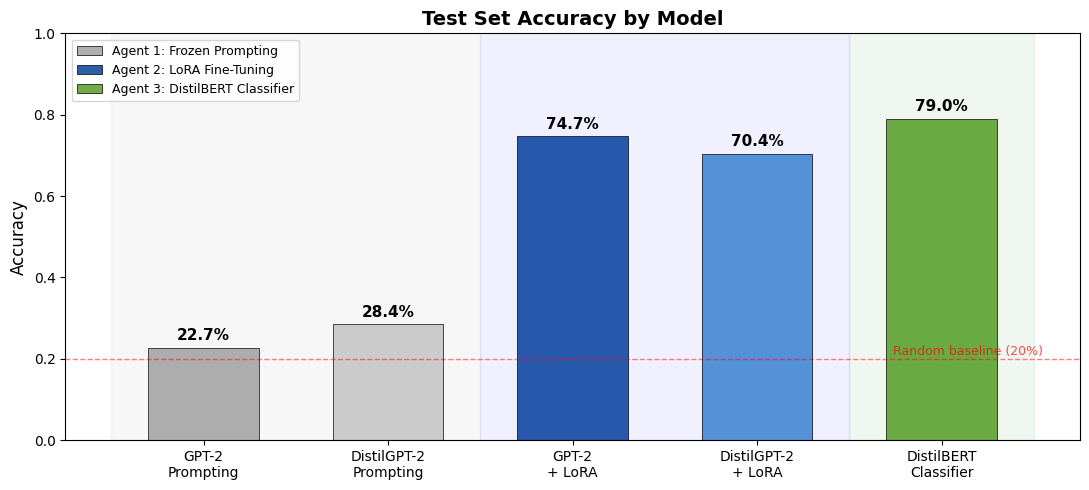

In [21]:
# Accuracy comparison by agent
fig, ax = plt.subplots(figsize=(11, 5))

model_names = ["GPT-2\nPrompting", "DistilGPT-2\nPrompting", "GPT-2\n+ LoRA", "DistilGPT-2\n+ LoRA", "DistilBERT\nClassifier"]
accuracies = [gpt2_acc, distilgpt2_acc, gpt2_lora_acc, distilgpt2_lora_acc, distilbert_acc]
colors = ["#b0b0b0", "#d0d0d0", "#2b5ea7", "#5b9bd5", "#70ad47"]

bars = ax.bar(model_names, accuracies, color=colors, edgecolor="black", linewidth=0.5, width=0.6)
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.012,
            f"{acc:.1%}", ha="center", va="bottom", fontweight="bold", fontsize=11)

ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Test Set Accuracy by Model", fontsize=14, fontweight="bold")
ax.set_ylim(0, 1.0)
ax.axhline(y=0.2, color="red", linestyle="--", alpha=0.5, linewidth=1)
ax.text(4.55, 0.21, "Random baseline (20%)", color="red", alpha=0.7, fontsize=9, ha="right")

# Agent region shading
ax.axvspan(-0.5, 1.5, alpha=0.06, color="gray")
ax.axvspan(1.5, 3.5, alpha=0.06, color="blue")
ax.axvspan(3.5, 4.5, alpha=0.06, color="green")

# Agent legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#b0b0b0", edgecolor="black", linewidth=0.5, label="Agent 1: Frozen Prompting"),
    Patch(facecolor="#2b5ea7", edgecolor="black", linewidth=0.5, label="Agent 2: LoRA Fine-Tuning"),
    Patch(facecolor="#70ad47", edgecolor="black", linewidth=0.5, label="Agent 3: DistilBERT Classifier"),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=9)

plt.tight_layout()
plt.show()

The accuracy bar chart shows a clear staircase pattern across the three agents. **Agent 1** (gray bars) performs near the 20% random baseline — frozen GPT-2 models have no understanding of the classification task and rely on superficial token co-occurrence patterns. **Agent 2** (blue bars) makes a massive leap: LoRA fine-tuning lifts accuracy by +42 to +52 percentage points despite training less than 1.3% of model parameters. Within Agent 2, the larger GPT-2 (74.7%) outperforms DistilGPT-2 (70.4%), confirming that model capacity matters even with parameter-efficient fine-tuning. **Agent 3** (green bar) achieves the best accuracy (79.0%) with DistilBERT, a model specifically designed for classification tasks — its bidirectional attention and native cross-entropy training give it an inherent advantage over generative models repurposed for classification.

### 5.3 Per-Class F1-Score Analysis

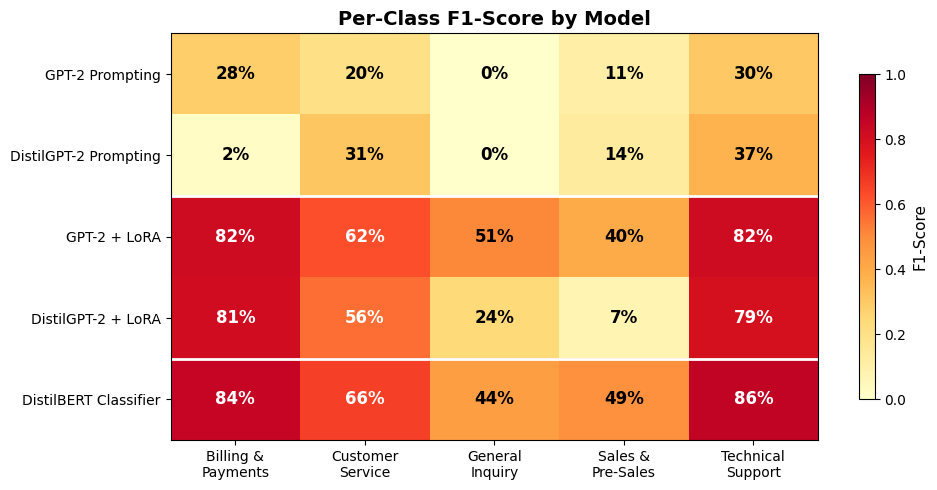

In [22]:
# Per-class F1-score heatmap
from sklearn.metrics import classification_report as cr

model_labels = ["GPT-2 Prompting", "DistilGPT-2 Prompting", "GPT-2 + LoRA", "DistilGPT-2 + LoRA", "DistilBERT Classifier"]
all_preds = [gpt2_preds, distilgpt2_preds, gpt2_lora_preds, distilgpt2_lora_preds, distilbert_preds]
all_true = [gpt2_true, distilgpt2_true, gpt2_lora_true, distilgpt2_lora_true, distilbert_true]

# Build F1 matrix (rows = models, columns = classes)
f1_matrix = []
for preds, true in zip(all_preds, all_true):
    report = cr(true, preds, target_names=label_list, output_dict=True, zero_division=0)
    f1_matrix.append([report[label]["f1-score"] for label in label_list])

f1_array = np.array(f1_matrix)
class_labels = ["Billing &\nPayments", "Customer\nService", "General\nInquiry", "Sales &\nPre-Sales", "Technical\nSupport"]

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(f1_array, cmap="YlOrRd", aspect="auto", vmin=0, vmax=1)

# Annotate each cell with F1 value
for i in range(len(model_labels)):
    for j in range(len(class_labels)):
        val = f1_array[i, j]
        color = "white" if val > 0.55 else "black"
        ax.text(j, i, f"{val:.0%}", ha="center", va="center", fontsize=12, fontweight="bold", color=color)

# Draw horizontal lines to separate agents
ax.axhline(y=1.5, color="white", linewidth=2)
ax.axhline(y=3.5, color="white", linewidth=2)

ax.set_xticks(range(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticks(range(len(model_labels)))
ax.set_yticklabels(model_labels, fontsize=10)
ax.set_title("Per-Class F1-Score by Model", fontsize=14, fontweight="bold")

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("F1-Score", fontsize=11)

plt.tight_layout()
plt.show()

The F1 heatmap reveals how each agent handles the 5 classes differently:

- **Technical Support** (largest class, 849 test samples): All fine-tuned models perform well here (79–86% F1), while frozen models struggle (30–37%). The large sample size gives every model enough signal to learn this class.
- **Billing and Payments** (291 samples): A similar pattern — frozen models score 2–28% F1, while fine-tuned models jump to 81–84% F1. This class has distinctive vocabulary (invoices, charges, refunds) that fine-tuning can capture.
- **Customer Service** (395 samples): The hardest large class. Even DistilBERT only reaches 66% F1. Emails in this category overlap semantically with Technical Support and Billing, making them inherently ambiguous.
- **General Inquiry** (29 samples) and **Sales and Pre-Sales** (93 samples): These minority classes expose the biggest differences between models. GPT-2+LoRA handles them best among the generative models (51% and 40% F1), while DistilGPT-2+LoRA struggles significantly (24% and 7% F1). DistilBERT achieves 44% and 49% F1 respectively — better than DistilGPT-2+LoRA but comparable to GPT-2+LoRA. The extreme class imbalance (29 vs 849 samples) remains the primary bottleneck for these classes.

### 5.4 Computational Efficiency

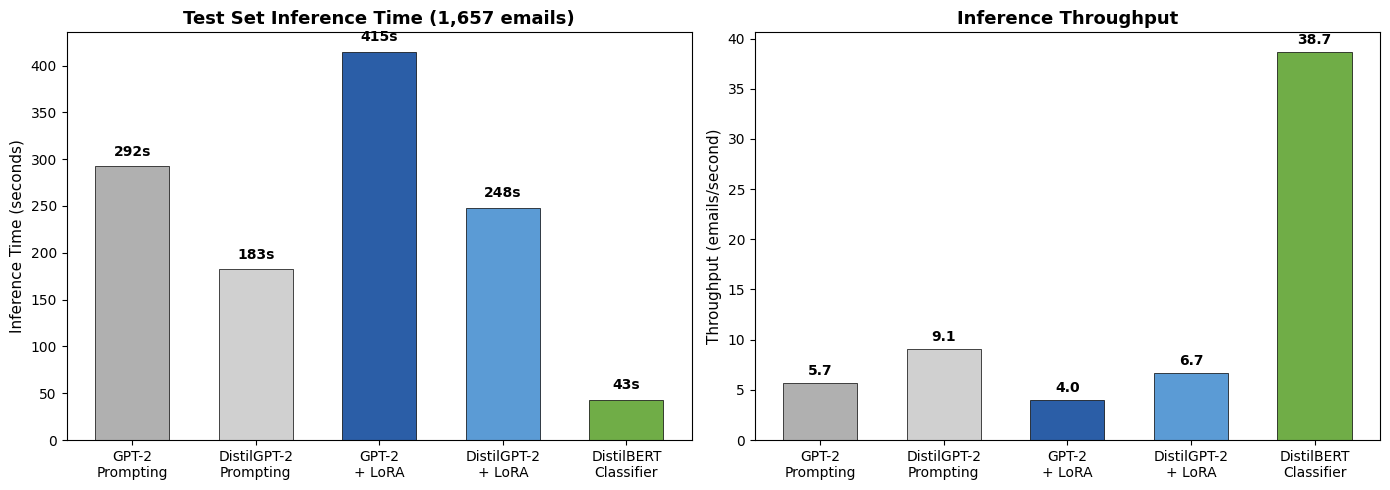

In [23]:
# Computational efficiency comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = ["GPT-2\nPrompting", "DistilGPT-2\nPrompting", "GPT-2\n+ LoRA", "DistilGPT-2\n+ LoRA", "DistilBERT\nClassifier"]
times = [gpt2_time, distilgpt2_time, gpt2_lora_time, distilgpt2_lora_time, distilbert_time]
throughputs = [1657 / t for t in times]
colors = ["#b0b0b0", "#d0d0d0", "#2b5ea7", "#5b9bd5", "#70ad47"]

# Left: Inference time
bars = axes[0].bar(model_names, times, color=colors, edgecolor="black", linewidth=0.5, width=0.6)
for bar, t in zip(bars, times):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 8,
                 f"{t:.0f}s", ha="center", va="bottom", fontweight="bold", fontsize=10)
axes[0].set_ylabel("Inference Time (seconds)", fontsize=11)
axes[0].set_title("Test Set Inference Time (1,657 emails)", fontsize=13, fontweight="bold")

# Right: Throughput
bars = axes[1].bar(model_names, throughputs, color=colors, edgecolor="black", linewidth=0.5, width=0.6)
for bar, tp in zip(bars, throughputs):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f"{tp:.1f}", ha="center", va="bottom", fontweight="bold", fontsize=10)
axes[1].set_ylabel("Throughput (emails/second)", fontsize=11)
axes[1].set_title("Inference Throughput", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.show()

The efficiency charts reveal a key trade-off and a surprising winner. **DistilBERT** (Agent 3) is both the most accurate *and* the fastest model — it processes ~39 emails/second, roughly **7x faster** than DistilGPT-2+LoRA and **10x faster** than GPT-2+LoRA. This is because DistilBERT classifies each email in a single forward pass, while GPT-2-based models must perform 5 separate forward passes (one per label) plus additional passes for multi-token labels using KV-cache.

Among the GPT-2 variants, **DistilGPT-2 is consistently ~1.6x faster** than GPT-2 (both frozen and LoRA), reflecting its 6-layer vs 12-layer architecture. Interestingly, LoRA fine-tuning makes GPT-2 *slower* than its frozen version (415s vs 292s) — the LoRA adapter layers add overhead to each forward pass when combined with KV-cache scoring.

For a production deployment, DistilBERT would be the clear choice: it classifies the full test set in ~43 seconds compared to ~7 minutes for the next-best model.

### 5.5 Confusion Matrices

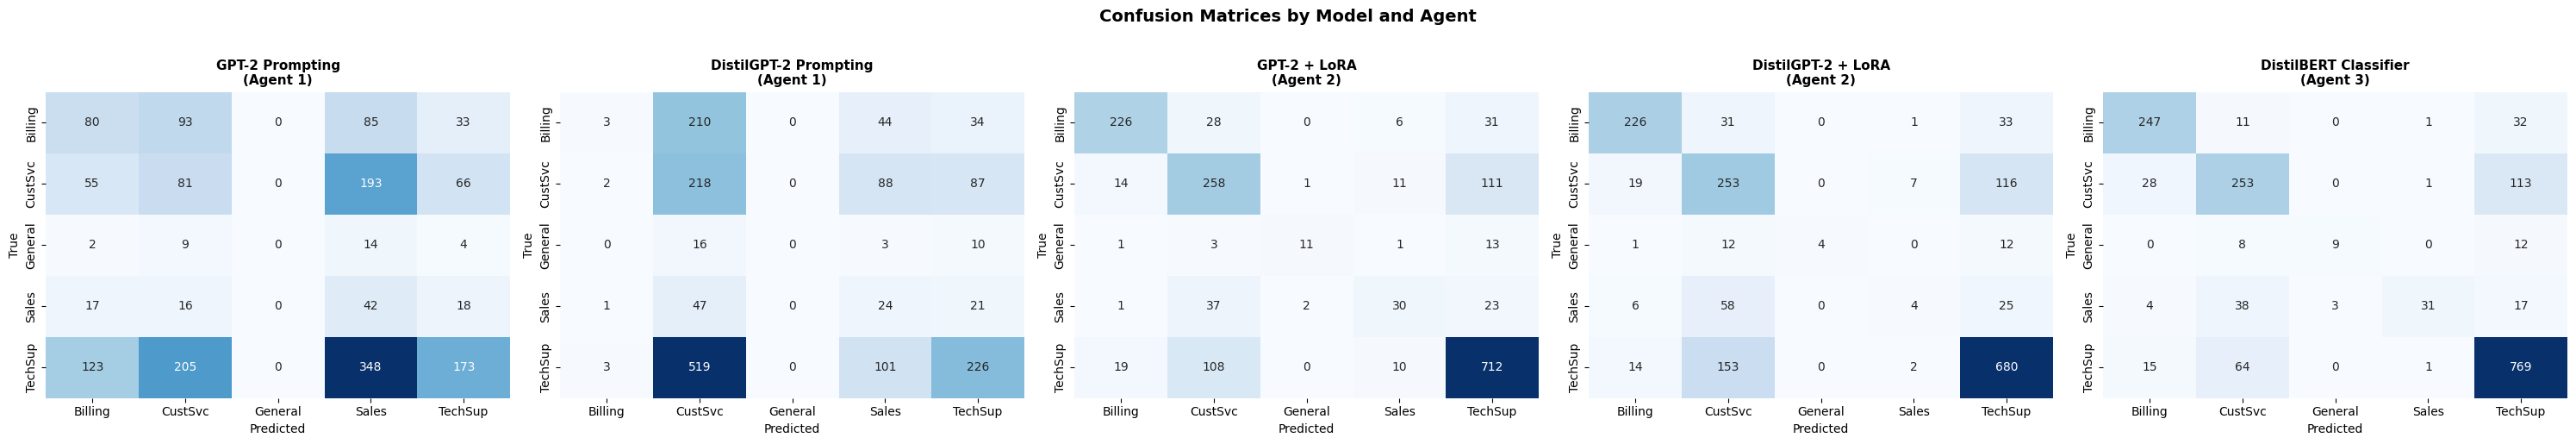

In [24]:
# Confusion matrices for all models
all_preds = [gpt2_preds, distilgpt2_preds, gpt2_lora_preds, distilgpt2_lora_preds, distilbert_preds]
all_true = [gpt2_true, distilgpt2_true, gpt2_lora_true, distilgpt2_lora_true, distilbert_true]
titles = ["GPT-2 Prompting\n(Agent 1)", "DistilGPT-2 Prompting\n(Agent 1)",
          "GPT-2 + LoRA\n(Agent 2)", "DistilGPT-2 + LoRA\n(Agent 2)",
          "DistilBERT Classifier\n(Agent 3)"]
short_labels = ["Billing", "CustSvc", "General", "Sales", "TechSup"]

fig, axes = plt.subplots(1, 5, figsize=(30, 5))
for ax, preds, true, title in zip(axes, all_preds, all_true, titles):
    cm = confusion_matrix(true, preds, labels=label_list)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=short_labels,
                yticklabels=short_labels, ax=ax, cbar=False)
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.suptitle("Confusion Matrices by Model and Agent", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

The confusion matrices visualize the error patterns for each model. Key observations:

- **Agent 1 (frozen models):** The matrices show near-random scattering with heavy bias toward one or two classes. GPT-2 over-predicts "Sales and Pre-Sales" while DistilGPT-2 over-predicts "Customer Service" — each model has a different token-frequency bias that dominates its predictions. The diagonal (correct predictions) is barely visible.
- **Agent 2 (LoRA models):** The diagonal becomes clearly dominant, showing that fine-tuning teaches the models to attend to email content rather than token frequency. The main confusion pattern is between "Customer Service" and "Technical Support" — both are large classes with overlapping vocabulary (software issues, account problems). GPT-2+LoRA shows a more balanced diagonal than DistilGPT-2+LoRA, which almost entirely misses "Sales and Pre-Sales" (only 4 correct out of 93).
- **Agent 3 (DistilBERT):** Shows the strongest diagonal and the most balanced predictions across all classes. The primary remaining error is "Customer Service" samples being predicted as "Technical Support" (and vice versa), which reflects genuine semantic overlap in the data. "Sales and Pre-Sales" also gets confused with "Technical Support", suggesting these classes share terminology around product features and technical capabilities.

### 5.6 Key Takeaways

1. **Zero-shot prompting fails for domain-specific classification.** Frozen GPT-2 models achieve near-random accuracy (22–28%), confirming that base language models lack the task-specific knowledge needed for email routing without fine-tuning.

2. **LoRA delivers outsized returns for minimal cost.** Training just ~1% of parameters produces +42 to +52 percentage point accuracy gains. This makes LoRA an excellent choice when compute or data is limited — it transforms a general-purpose language model into a usable classifier with minimal hardware requirements.

3. **Discriminative models outperform generative models for classification.** DistilBERT (79.0%) beats GPT-2+LoRA (74.7%) despite being a smaller model (67M vs 126M params). Its bidirectional attention and native classification objective give it a structural advantage for this task.

4. **DistilBERT is both faster and more accurate.** At ~39 emails/second (vs ~4 for GPT-2+LoRA), DistilBERT is the clear production choice — it achieves the best accuracy with 10x faster inference.

5. **Class imbalance remains the primary bottleneck.** All models struggle with "General Inquiry" (29 training samples) and "Sales and Pre-Sales" (93 samples). Techniques like oversampling, class-weighted loss, or data augmentation could improve minority-class performance in future work.